# Cutting plane and bundle methods
The second part of the tutorial focuses on cutting plane and bundle
methods. We aim at resolving the following LASSO problem:
$$
\min_r \;f(r) =  \| A u - b \|_2^2 + \lambda \|u \|_1
$$
with $\lambda$ a given regularization parameter, $X$ and $b$ input data.

## Settings
We import the usual packages:

In [1]:
using Printf, Random
using LinearAlgebra
using ForwardDiff
using JuMP, CPLEX

Fix seed

In [2]:
Random.seed!(2713);

Some constants

In [3]:
const LB = 0 #For CPLEX
const UB =  1e20
const SOLVER = CPLEX.Optimizer

CPLEX.Optimizer

We first generate artificial data to study the algorithm:

In [4]:
include("data.jl")

nVariables = 10;
nCassures = 10;
xMin, xMax = build_bounds(nVariables)
A = build_X(nVariables, nCassures, xMin, xMax);
b = randn(nCassures);
λ = 50.0;

Build oracle for objective:

In [5]:
f(u) = 0.5 * norm(A*u - b, 2)^2 + λ * norm(u, 1);

Function that gets the actual solution:

In [6]:
function get_solution(A, b, λ)
    n, m = size(A)
    model = Model(SOLVER)
    JuMP.set_silent(model)
    set_optimizer_attribute(model, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    # Variable u
    @variable(model, u[1:n])
    # Variable t, linearizing the \|.\|_1 term
    @variable(model, t[1:n])
    @constraint(model, t .>= u)
    @constraint(model, t .>= -u)
    @objective(model, Min, 0.5 * dot(A*u - b, A*u - b) + λ * sum(t))
    JuMP.optimize!(model)
    return JuMP.objective_value(model)
end
optsol = get_solution(A, b, λ)
println("Optimal solution is equal to ", optsol)

Optimal solution is equal to 5.0541025315605985


## A note on the choice of solvers : 

Despite CPLEX being the faster solver of the two, we generally preferred using OSQP here due to numerical issues. In particular, here are a couple of our observations.
- CPLEX (sometimes ?) does not deal very well with the very low lower bound LB. It appears that the bound is so low that it believes the problem to be unbounded (especially using the bundle method). Here we have an obvious reasonable lower bound of 0, but that might not be the case in other applications.

## Cutting plane
The cutting plane method builds a proxy $\underline{f}_k$ for the original
function $f$, such that $\underline{f}_k$ is polyhedral and is a lower approximation:
$$
\underline{f}_k \leq f \quad \forall k
$$
If we have at disposal a collection of point $x_1, \cdots, x_k$,
with associated subgradients $g_1, \cdots, g_k$, the function
$\underline{f}_k$ writes out
$$
\begin{aligned}
f_k(x) = min_x \;& \theta  \\
         s.t. \quad & \theta \geq g_k^\top (x - x_k) + f(x_k)
\end{aligned}
$$

We can define the cutting plane algorithm as follows.

In [7]:
function launch_cutting_plane(X, xMin, xMax, maxit=5000)
    master = Model(SOLVER)
    JuMP.set_silent(master)
    set_optimizer_attribute(master, "CPX_PARAM_LPMETHOD", 2) #For CPLEX

    @variable(master, α >= LB) 
    @variable(master, xMin[i] <= x[i in 1:size(X,1)] <= xMax[i])
    @objective(master, Min, α)
    
    lb, ub = LB, UB

    best_ub = ub

    epsilon = 1e-8
    
    trace_f = Float64[]
    trace_ub = Float64[]
    trace_lb = Float64[]
    
    for n_iter in 1:maxit
        println("Iteration : ",n_iter)
        JuMP.optimize!(master)
        lb = JuMP.value(α)
        x_k = JuMP.value.(x)
        f_k = f(x_k)
        println("Lower bound : ", lb)
        println("Valeur au point courant : ", f_k)
        g_k = ForwardDiff.gradient(f, x_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_lb, lb)
        if (f_k - lb <= epsilon)
            return trace_f, trace_ub, trace_lb, n_iter
            break
        else
            @constraint(master, α >= f_k + sum(g_k[i]*(x-x_k)[i] for i in 1:size(X,1)))
        end
    end
    return trace_f, trace_ub, trace_lb, maxit
end;

In [8]:
trace_cutting_plane_f, trace_cutting_plane_ub, trace_cutting_plane_lb, n_cutting_plane  = launch_cutting_plane(A,xMin,xMax)

Iteration : 1
Lower bound : 0.0
Valeur au point courant : 8.881330164947744e6
Iteration : 2
Lower bound : 0.0
Valeur au point courant : 4.2405402773302505e6
Iteration : 3
Lower bound : 0.0
Valeur au point courant : 1.563300208359224e6
Iteration : 4
Lower bound : 0.0
Valeur au point courant : 1.8450035151468567e6
Iteration : 5
Lower bound : 0.0
Valeur au point courant : 1.8423293662163655e6
Iteration : 6
Lower bound : 0.0
Valeur au point courant : 2.669615431579714e6
Iteration : 7
Lower bound : 0.0
Valeur au point courant : 1.3376513995417422e6
Iteration : 8
Lower bound : 0.0
Valeur au point courant : 2.041235750929141e6
Iteration : 9
Lower bound : 0.0
Valeur au point courant : 1.51917123839853e6
Iteration : 10
Lower bound : 0.0
Valeur au point courant : 1.02964903749743e6
Iteration : 11
Lower bound : 0.0
Valeur au point courant : 1.221582403431801e6
Iteration : 12
Lower bound : 0.0
Valeur au point courant : 856798.4893378295
Iteration : 13
Lower bound : 0.0
Valeur au point courant : 93

Valeur au point courant : 4909.962060483889
Iteration : 134
Lower bound : 0.0
Valeur au point courant : 6291.195877386541
Iteration : 135
Lower bound : 0.0
Valeur au point courant : 4986.520152414142
Iteration : 136
Lower bound : 0.0
Valeur au point courant : 3830.6015774243515
Iteration : 137
Lower bound : 0.0
Valeur au point courant : 5026.828368369842
Iteration : 138
Lower bound : 0.0
Valeur au point courant : 4868.677833762888
Iteration : 139
Lower bound : 0.0
Valeur au point courant : 3730.3898216842595
Iteration : 140
Lower bound : 0.0
Valeur au point courant : 3575.595057010416
Iteration : 141
Lower bound : 0.0
Valeur au point courant : 3250.4062442285795
Iteration : 142
Lower bound : 0.0
Valeur au point courant : 2931.033247567376
Iteration : 143
Lower bound : 0.0
Valeur au point courant : 3437.4774785959307
Iteration : 144
Lower bound : 0.0
Valeur au point courant : 6185.199517659415
Iteration : 145
Lower bound : 0.0
Valeur au point courant : 2803.229256554333
Iteration : 146


Valeur au point courant : 7.318321385815792
Iteration : 266
Lower bound : 4.296831126461082
Valeur au point courant : 6.856892554302723
Iteration : 267
Lower bound : 4.336989660475315
Valeur au point courant : 7.733370567416342
Iteration : 268
Lower bound : 4.389223034824739
Valeur au point courant : 6.993292409503191
Iteration : 269
Lower bound : 4.400052155459418
Valeur au point courant : 5.9452311898662895
Iteration : 270
Lower bound : 4.458341242497426
Valeur au point courant : 6.6591797304119815
Iteration : 271
Lower bound : 4.574190783812823
Valeur au point courant : 6.42759395409207
Iteration : 272
Lower bound : 4.630139294457258
Valeur au point courant : 6.634931091698252
Iteration : 273
Lower bound : 4.651880813779963
Valeur au point courant : 6.431140843365593
Iteration : 274
Lower bound : 4.698748176459613
Valeur au point courant : 5.678727485091873
Iteration : 275
Lower bound : 4.715434577412642
Valeur au point courant : 5.847769950519263
Iteration : 276
Lower bound : 4.743

Iteration : 377
Lower bound : 5.054101726893732
Valeur au point courant : 5.0541068777423845
Iteration : 378
Lower bound : 5.054101796137681
Valeur au point courant : 5.05410680057321
Iteration : 379
Lower bound : 5.05410201151571
Valeur au point courant : 5.054104226495593
Iteration : 380
Lower bound : 5.054102037643447
Valeur au point courant : 5.0541036785622
Iteration : 381
Lower bound : 5.05410205247977
Valeur au point courant : 5.054103528750927
Iteration : 382
Lower bound : 5.054102083249771
Valeur au point courant : 5.054103756614706
Iteration : 383
Lower bound : 5.054102234583406
Valeur au point courant : 5.054104133740388
Iteration : 384
Lower bound : 5.054102266291613
Valeur au point courant : 5.054104233589492
Iteration : 385
Lower bound : 5.054102283229179
Valeur au point courant : 5.054103356089662
Iteration : 386
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 387
Lower bound : 5.054102286471145
Valeur au point courant : 5.05410307

Valeur au point courant : 5.054103079701353
Iteration : 507
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 508
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 509
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 510
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 511
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 512
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 513
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 514
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 515
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 516
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 517
Lower bound : 5.0541

Valeur au point courant : 5.054103079701353
Iteration : 648
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 649
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 650
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 651
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 652
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 653
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 654
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 655
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 656
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 657
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 658
Lower bound : 5.0541

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 782
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 783
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 784
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 785
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 786
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 787
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 788
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 789
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 790
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 791
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iter

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 912
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 913
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 914
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 915
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 916
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 917
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 918
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 919
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 920
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 921
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iter

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1023
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1024
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1025
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1026
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1027
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1028
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1029
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1030
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1031
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1032
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Valeur au point courant : 5.054103079701353
Iteration : 1143
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1144
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1145
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1146
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1147
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1148
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1149
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1150
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1151
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1152
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1153
Lower bou

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1252
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1253
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1254
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1255
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1256
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1257
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1258
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1259
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1260
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1261
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Iteration : 1354
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1355
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1356
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1357
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1358
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1359
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1360
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1361
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1362
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1363
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1364
Lower bound : 5.054102286471145
Valeur au point coura

Iteration : 1450
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1451
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1452
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1453
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1454
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1455
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1456
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1457
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1458
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1459
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1460
Lower bound : 5.054102286471145
Valeur au point coura

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1618
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1619
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1620
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1621
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1622
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1623
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1624
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1625
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1626
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1627
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1708
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1709
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1710
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1711
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1712
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1713
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1714
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1715
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1716
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1717
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Iteration : 1796
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1797
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1798
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1799
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1800
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1801
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1802
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1803
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1804
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1805
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1806
Lower bound : 5.054102286471145
Valeur au point coura

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1885
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1886
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1887
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1888
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1889
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1890
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1891
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1892
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1893
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 1894
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2104
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2105
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2106
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2107
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2108
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2109
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2110
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2111
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2112
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2113
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2239
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2240
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2241
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2242
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2243
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2244
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2245
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2246
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2247
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2248
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2387
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2388
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2389
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2390
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2391
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2392
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2393
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2394
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2395
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2396
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2519
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2520
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2521
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2522
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2523
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2524
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2525
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2526
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2527
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2528
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2645
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2646
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2647
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2648
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2649
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2650
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2651
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2652
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2653
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2654
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2778
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2779
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2780
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2781
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2782
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2783
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2784
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2785
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2786
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2787
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2910
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2911
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2912
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2913
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2914
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2915
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2916
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2917
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2918
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 2919
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3021
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3022
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3023
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3024
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3025
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3026
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3027
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3028
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3029
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3030
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3134
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3135
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3136
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3137
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3138
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3139
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3140
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3141
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3142
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3143
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3244
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3245
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3246
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3247
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3248
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3249
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3250
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3251
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3252
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3253
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3361
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3362
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3363
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3364
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3365
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3366
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3367
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3368
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3369
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3370
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3469
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3470
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3471
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3472
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3473
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3474
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3475
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3476
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3477
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3478
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3571
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3572
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3573
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3574
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3575
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3576
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3577
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3578
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3579
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3580
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3678
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3679
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3680
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3681
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3682
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3683
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3684
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3685
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3686
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3687
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3785
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3786
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3787
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3788
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3789
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3790
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3791
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3792
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3793
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3794
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Iteration : 3894
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3895
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3896
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3897
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3898
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3899
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3900
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3901
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3902
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3903
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3904
Lower bound : 5.054102286471145
Valeur au point coura

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3994
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3995
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3996
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3997
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3998
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 3999
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4000
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4001
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4002
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4003
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4093
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4094
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4095
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4096
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4097
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4098
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4099
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4100
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4101
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4102
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4225
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4226
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4227
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4228
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4229
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4230
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4231
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4232
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4233
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4234
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4345
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4346
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4347
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4348
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4349
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4350
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4351
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4352
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4353
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4354
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Iteration : 4471
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4472
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4473
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4474
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4475
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4476
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4477
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4478
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4479
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4480
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4481
Lower bound : 5.054102286471145
Valeur au point coura

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4595
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4596
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4597
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4598
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4599
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4600
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4601
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4602
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4603
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4604
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4714
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4715
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4716
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4717
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4718
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4719
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4720
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4721
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4722
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4723
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4815
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4816
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4817
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4818
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4819
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4820
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4821
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4822
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4823
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4824
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4926
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4927
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4928
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4929
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4930
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4931
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4932
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4933
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4934
Lower bound : 5.054102286471145
Valeur au point courant : 5.054103079701353
Iteration : 4935
Lower bound : 5.054102286471145
Valeur au point courant : 5.0541030797

([8.881330164947744e6, 4.2405402773302505e6, 1.563300208359224e6, 1.8450035151468567e6, 1.8423293662163655e6, 2.669615431579714e6, 1.3376513995417422e6, 2.041235750929141e6, 1.51917123839853e6, 1.02964903749743e6  …  5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353], [8.881330164947744e6, 4.2405402773302505e6, 1.563300208359224e6, 1.563300208359224e6, 1.563300208359224e6, 1.563300208359224e6, 1.3376513995417422e6, 1.3376513995417422e6, 1.3376513995417422e6, 1.02964903749743e6  …  5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353, 5.054103079701353], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  5.054102286471145, 5.054102286471145, 5.054102286471145, 5.054102286471145, 5.054102286471145, 5.054102286471145, 5.05410228647114

In [11]:
trace_cutting_plane_f[length(trace_cutting_plane_f)] - trace_cutting_plane_lb[length(trace_cutting_plane_lb)]

7.932302077406916e-7

In [10]:
trace_cutting_plane_f[length(trace_cutting_plane_f)] - optsol

5.481407541196859e-7

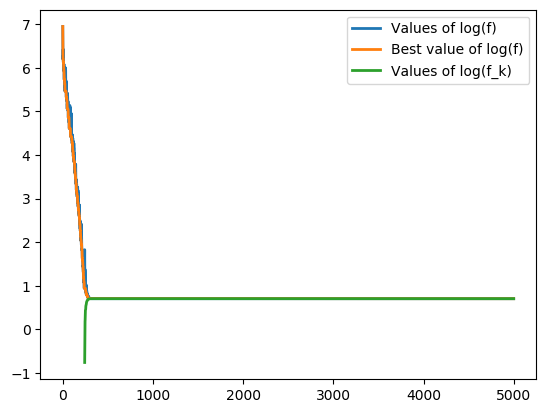

PyObject <matplotlib.legend.Legend object at 0x16d9df750>

In [12]:
using PyPlot

plot(log10.(trace_cutting_plane_f), lw=2., label = "Values of log(f)")
plot(log10.(trace_cutting_plane_ub), lw=2., label ="Best value of log(f)")
plot(log10.(abs.(trace_cutting_plane_lb)), lw=2., label ="Values of log(f_k)")
legend()

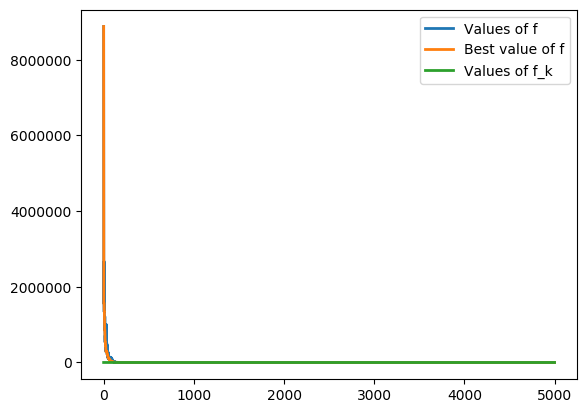

PyObject <matplotlib.legend.Legend object at 0x16dd4af10>

In [13]:
plot(trace_cutting_plane_f, lw=2., label = "Values of f")
plot(trace_cutting_plane_ub, lw=2., label ="Best value of f")
plot(trace_cutting_plane_lb, lw=2., label ="Values of f_k")
legend()

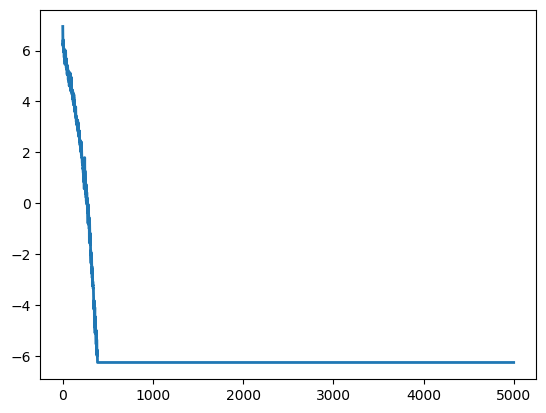

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x155c77350>

In [14]:
plot(log10.(trace_cutting_plane_f .- optsol), lw=2.)

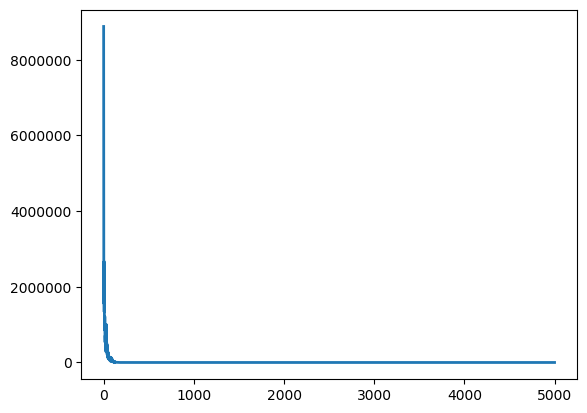

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x16e71a6d0>

In [15]:
plot(trace_cutting_plane_f .- optsol, lw=2.)

## Bundle algorithm
Comparing to the cutting plane method, the bundle algorithm adds a
quadratic penalization to the polyhedral proxy model.
The function .
$$
\begin{aligned}
f_k(x) = min_x \;& \theta + \frac 12 \| x - x_k \|_2^2 \\
         s.t. \quad & \theta \geq g_k^\top (x - x_k) + f(x_k)
\end{aligned}
$$

In [16]:
function launch_bundle(X, xMin, xMax, maxit=5000)
    master = Model(SOLVER)
    JuMP.set_silent(master)
    set_optimizer_attribute(master, "CPX_PARAM_LPMETHOD", 2) #For CPLEX
    @variable(master, α >= LB)
    @variable(master, xMin[i] <= y[i in 1:size(X,1)] <= xMax[i])
    
    lb, ub = LB, UB

    best_ub = ub

    trace_f = Float64[]
    trace_ub = Float64[]
    trace_lb = Float64[]
    
    prediction = 0.0
    # Number of serious step
    nb_ss = 0
    # Number of null step
    nb_ns = 0
    # Maximum number of update
    nb_update = 3
    step = "NONE"
    weight = 1.0 #c = 0.5
    tol = 1e-1
    EPS = 1e-8

    x_k = zeros(nVariables)
    
    # The objective writes out as a QP
    @objective(master, Min, α + weight*sum((y[i]-x_k[i])^2 for i in 1:nVariables))
    
    for n_iter in 1:maxit
        JuMP.optimize!(master)
        println("Iteration ", n_iter)
        lb = JuMP.value(α)
        y_k = JuMP.value.(y)
        f_k = f(y_k)
        println("Lower bound : ", lb)
        println("Function value : ", f_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        f_x_k = f(x_k)
        delta_k = f_x_k - lb - weight*norm(y_k-x_k,2)^2
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_lb, lb)
        
        if delta_k <= EPS
            println("Optimum reached within epsilon threshold.")
            println("Number of serious steps :", nb_ss)
            println("Number of null steps :", nb_ns)
            return trace_f, trace_ub, trace_lb, n_iter, nb_ss, nb_ns
        else
            if f_x_k - f_k >= tol*delta_k
                # Serious step
                nb_ss += 1
                println("Serious step.")
                x_k = y_k
            else
                #Null step
                println("Null step.")
                nb_ns += 1
            end
        end
        g_k = ForwardDiff.gradient(f, y_k)
        @constraint(master, α >= f_k + sum(g_k[i]*(y-y_k)[i] for i in 1:size(X,1)))
        
    end
    println("Number of serious steps :", nb_ss)
    println("Number of null steps :", nb_ns)
    return trace_f, trace_ub, trace_lb, maxit, nb_ss, nb_ns
end

launch_bundle (generic function with 2 methods)

In [17]:
trace_bundle_f, trace_bundle_ub, trace_bundle_lb, n_bundle, nb_ss, nb_ns = launch_bundle(A,xMin,xMax)

Iteration 1
Lower bound : 0.0
Function value : 5.5995940672380655
Null step.
Iteration 2
Lower bound : 1.501079434785831e-10
Function value : 7.5722472376899255
Null step.
Iteration 3
Lower bound : 1.4464247741460596e-10
Function value : 9.275417113985618
Null step.
Iteration 4
Lower bound : 6.302161067339904e-11
Function value : 14.095415683541308
Null step.
Iteration 5
Lower bound : 2.3075646757011883e-11
Function value : 17.59268816842602
Null step.
Iteration 6
Lower bound : 2.314028290204025e-10
Function value : 39.98218534660518
Null step.
Iteration 7
Lower bound : 4.3423667092153524e-11
Function value : 51.72427970449159
Null step.
Iteration 8
Lower bound : 1.6314564989963183e-11
Function value : 84.60256900842923
Null step.
Iteration 9
Lower bound : 4.809358827312342e-11
Function value : 202.85198898618387
Null step.
Iteration 10
Lower bound : 0.48391502624618327
Function value : 63.51536495172119
Null step.
Iteration 11
Lower bound : 0.5475385924086058
Function value : 111.1022

Iteration 95
Lower bound : 5.052444509458818
Function value : 5.056915936850373
Serious step.
Iteration 96
Lower bound : 5.0525495283945645
Function value : 5.0587310359232545
Null step.
Iteration 97
Lower bound : 5.05289525593585
Function value : 5.056698213624245
Null step.
Iteration 98
Lower bound : 5.053304945758545
Function value : 5.060162105279409
Null step.
Iteration 99
Lower bound : 5.053326644041086
Function value : 5.056218028949985
Serious step.
Iteration 100
Lower bound : 5.053388311410917
Function value : 5.056461083833673
Null step.
Iteration 101
Lower bound : 5.053411156328402
Function value : 5.057106571727422
Null step.
Iteration 102
Lower bound : 5.053532006473169
Function value : 5.055923125693032
Serious step.
Iteration 103
Lower bound : 5.053624202930366
Function value : 5.055404379762834
Serious step.
Iteration 104
Lower bound : 5.0536938068509665
Function value : 5.0553257006356125
Null step.
Iteration 105
Lower bound : 5.05371786615713
Function value : 5.054543

Iteration 189
Lower bound : 5.054102550109177
Function value : 5.054102573932583
Serious step.
Iteration 190
Lower bound : 5.0541026054283344
Function value : 5.054102706595522
Optimum reached within epsilon threshold.
Number of serious steps :37
Number of null steps :152


([5.5995940672380655, 7.5722472376899255, 9.275417113985618, 14.095415683541308, 17.59268816842602, 39.98218534660518, 51.72427970449159, 84.60256900842923, 202.85198898618387, 63.51536495172119  …  5.0541026232235495, 5.054102620671821, 5.054102645876025, 5.054102594689277, 5.054102585914154, 5.054102582260011, 5.054102585647335, 5.054102635750212, 5.054102573932583, 5.054102706595522], [5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655, 5.5995940672380655  …  5.054102612079711, 5.054102612079711, 5.054102612079711, 5.054102594689277, 5.054102585914154, 5.054102582260011, 5.054102582260011, 5.054102582260011, 5.054102573932583, 5.054102573932583], [0.0, 1.501079434785831e-10, 1.4464247741460596e-10, 6.302161067339904e-11, 2.3075646757011883e-11, 2.314028290204025e-10, 4.3423667092153524e-11, 1.6314564989963183e-11, 4.809358827312342e-11, 0.48391502624618327 

In [18]:
trace_bundle_f[length(trace_bundle_f)] - optsol

1.7503492344417282e-7

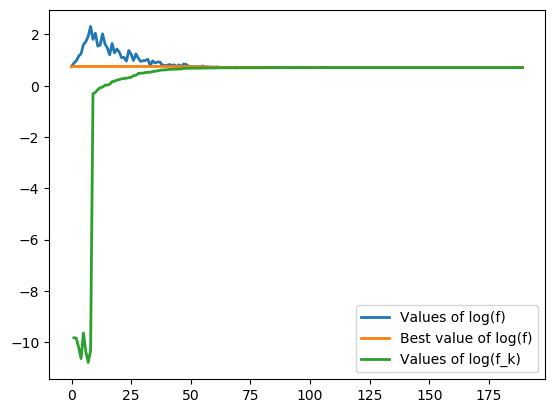

PyObject <matplotlib.legend.Legend object at 0x16f8ada90>

In [19]:
plot(log10.(trace_bundle_f), lw=2., label = "Values of log(f)")
plot(log10.(trace_bundle_ub), lw=2., label ="Best value of log(f)")
plot(log10.(abs.(trace_bundle_lb)), lw=2., label ="Values of log(f_k)")
legend()

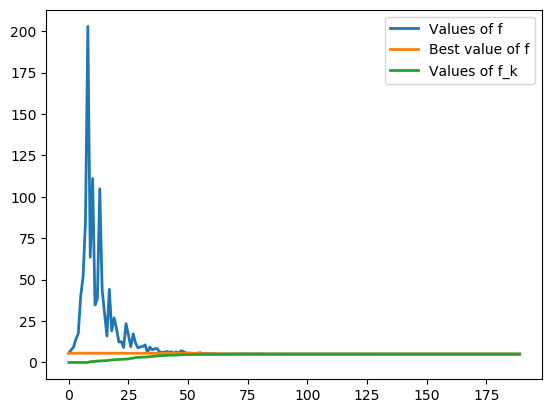

PyObject <matplotlib.legend.Legend object at 0x16fa6cb10>

In [20]:
plot(trace_bundle_f, lw=2., label = "Values of f")
plot(trace_bundle_ub, lw=2., label ="Best value of f")
plot(trace_bundle_lb, lw=2., label ="Values of f_k")
legend()

In [21]:
trace_bundle_ub

190-element Array{Float64,1}:
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 5.5995940672380655
 ⋮                 
 5.054102621809192 
 5.054102612079711 
 5.054102612079711 
 5.054102612079711 
 5.054102612079711 
 5.054102594689277 
 5.054102585914154 
 5.054102582260011 
 5.054102582260011 
 5.054102582260011 
 5.054102573932583 
 5.054102573932583 

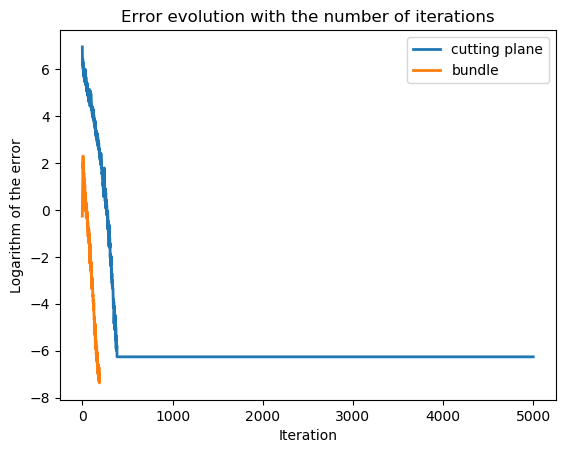

PyObject <matplotlib.legend.Legend object at 0x168083650>

In [22]:
plot(log10.(trace_cutting_plane_f .- optsol), lw=2., label = "cutting plane")
plot(log10.(trace_bundle_f .- optsol), lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Logarithm of the error")
legend()

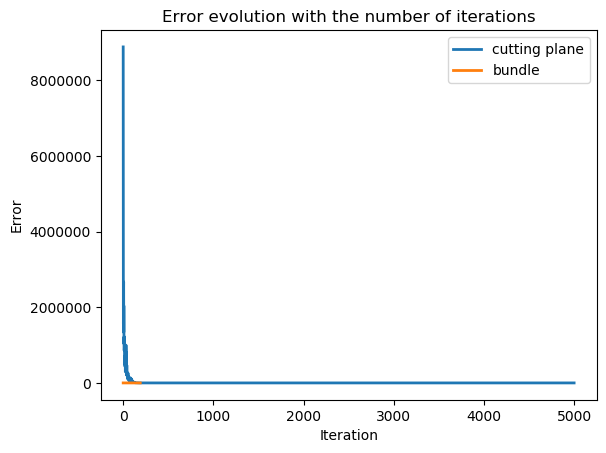

PyObject <matplotlib.legend.Legend object at 0x15584c6d0>

In [23]:
plot(trace_cutting_plane_f .- optsol, lw=2., label = "cutting plane")
plot(trace_bundle_f .- optsol, lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Error")
legend()

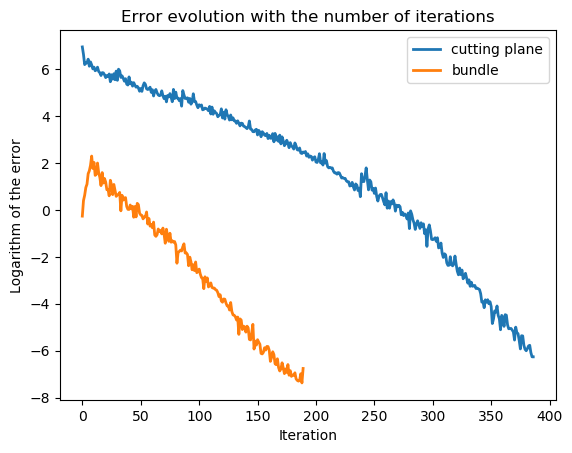

PyObject <matplotlib.legend.Legend object at 0x15584c810>

In [24]:
plot(log10.(trace_cutting_plane_f .- optsol)[1:387], lw=2., label = "cutting plane")
plot(log10.(trace_bundle_f .- optsol), lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Logarithm of the error")
legend()

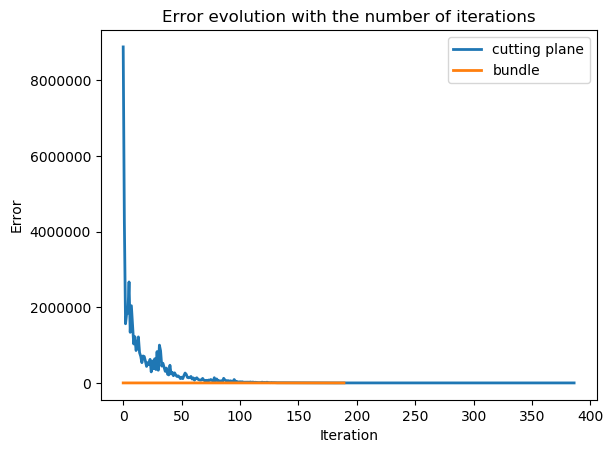

PyObject <matplotlib.legend.Legend object at 0x16f68ead0>

In [25]:
plot((trace_cutting_plane_f .- optsol)[1:387], lw=2., label = "cutting plane")
plot(trace_bundle_f .- optsol, lw=2., label = "bundle")
title("Error evolution with the number of iterations")
xlabel("Iteration")
ylabel("Error")
legend()